In [ ]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import os
import scipy.io as sio
from scipy import signal

In [1]:
import pandas as pd
import numpy as np
import wfdb
import math
import ast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.utils import to_categorical
sr =100

with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


In [ ]:
import numpy as np
from scipy import signal
with tf.device('/CPU:0'):
    # Define the filter parameters
    fs = 100  # Sampling frequency (Hz)
    lowcut = 0.5  # Lower cutoff frequency (Hz)
    highcut = 40.0  # Higher cutoff frequency (Hz)
    filter_order = 4  # Filter order

    def bandpass(X, fs, lowcut, highcut, filter_order):
        # Apply bandpass filter to each channel
        filtered_data = np.zeros_like(X)
        for i in range(X.shape[2]):
            for j in range(X.shape[0]):
                b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
                filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

        # Print the shape of the filtered data
        return filtered_data

GAN Presets

In [ ]:
X_co = X.copy()

In [2]:
gan_data_length = 2000
gan_data = np.load('../')
#X__ = np.append(X_co, gan_data)

In [ ]:
X = np.concatenate((X_co, gan_data), axis=0)

In [ ]:
new_rows = pd.DataFrame({
    'patient_id': np.arange(len(Y) + 1, len(Y) + 1 + gan_data_length),
    'age': np.floor(np.random.uniform(18, 25, gan_data_length)),
    'sex': np.random.randint(0, 2, gan_data_length),
})
Y = pd.concat([Y,new_rows])


array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [ ]:
with tf.device('/CPU:0'):
    def normalize(X, shape = False):
        # Compute mean and standard deviation along axis 1 and 2
        X_mean = np.mean(X)
        X_std = np.std(X)

        if(shape):
            print(X.shape)
        # Normalize data by subtracting mean and dividing by standard deviation
        return ((X - X_mean) / X_std)


    bld = 0.5
    def baseline_drift(X, baseline, range = 0):
        bld_range = (baseline-range, baseline+range)
        random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
        return X + random_shifts

In [ ]:
with tf.device('/GPU:0'):
    def da_apply(X, functions, shape = False):
        X_final = X.copy()

        # Applys DA Augments in specified order
        for func_dict in functions:
            func = func_dict['func']
            if(func_dict['params'] == None):
                X_final = func(X_final)     
            else:
                params = func_dict['params']
                X_final = func(X_final, *params)  

        if(shape == True):
            print(X_final.shape)

        return X_final

    #func_dict = [{'func': normalize, 'params': [None]}]

    #func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

    func_dict =[{'func': normalize, 'params': [None]},
                {'func': baseline_drift, 'params': [0,0.075]}]


    # func_dict =[{'func': bandpass, 'params': [sr, 0.5, 15, 3]}, # 100, 0.5, 10, 3. Change the sampling rate as necessary
    #             {'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
    #             {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [3]:

with tf.device('/GPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 18)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89) & (y_train >= 18)]

        rX_val = X_val[(y_val < 89) & (y_val >= 18)]
        ry_val = y_val[(y_val < 89) & (y_val >= 18)]

        rX_test = X_test[(y_test < 89) & (y_test >= 18)]
        ry_test = y_test[(y_test < 89) & (y_test >= 18)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X, Y, val_fold, test_fold, True)

MemoryError: Unable to allocate 1.52 GiB for an array with shape (17022, 1000, 12) and data type float64

In [ ]:
def data_subsetting(X, Y):

        Y_filtered = Y.age
        Y_filtered = Y_filtered.to_numpy()

        X_filtered = X[(Y_filtered < 89) & (Y_filtered >= 18)] # Additional filtering of patients older than 89 and younger than 18
        Y_filtered = Y_filtered[(Y_filtered < 89) & (Y_filtered >= 18)]
        Y_filtered_full = Y[(Y.age < 89) & (Y.age >= 18)]

        return X_filtered, Y_filtered, Y_filtered_full

X_filtered, Y_filtered, Y_filtered_full = data_subsetting(X_final, Y)

In [ ]:
import os

class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, save_path="../saved_models/100hz/age_models/"):
        super(SaveModelCallback, self).__init__()
        self.threshold = threshold
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss', None)
        if val_loss is not None and val_loss <= self.threshold:
            # Prepare the model name with the validation loss
            mod_name = f'age_model_val_loss_{val_loss:.4f}.h5'
            model_path = os.path.join(self.save_path, mod_name)
            # Save the entire model
            self.model.save(model_path)
            print(f'Model saved: {model_path}')
        elif val_loss is None:
            print("Validation loss is not available. Check if the validation data is provided and 'val_loss' is being computed.")

In [ ]:
with tf.device('/GPU:0'):
    # Batching
    batch_size = 64   # Batch size determines the amount of data processed each round
    num_epochs = 75   # All of the data is processed a certain number of time repetedly. Based on the number of epochs. 
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))   # Grouping the X and Y together. Similar to zipping

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(X_train))   # We are able to shuffle both the X and Y the same because they are grouped. 
    dataset = dataset.batch(batch_size)    # The input data is split into the batch size


    # Creating the model
    cnn_rnn_age_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.GlobalAveragePooling1D(),  # Global Average Pooling

        tf.keras.layers.RepeatVector(3),  # Prepares the input shape for LSTM after Global Pooling

        # Using Bidirectional LSTM and additional LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.BatchNormalization(),

        # Flattening the output to feed into a Dense layer
        tf.keras.layers.Flatten(),

        # Existing Dense Layers
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])


    # Compiling the model
    cnn_rnn_age_model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                        metrics = ['mse'])


    # Learning rate scheduler
    peak_saver = SaveModelCallback(threshold = 7.96)

    # Fitting the model
    if(not load_model):
        cnn_rnn_history = cnn_rnn_age_model.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=peak_saver)

Epoch 1/75
298/298 [==============================] - 56s 107ms/step - loss: 17.4442 - mse: 600.0905 - val_loss: 17.6388 - val_mse: 419.0403
Epoch 2/75
298/298 [==============================] - 29s 96ms/step - loss: 9.9844 - mse: 170.4140 - val_loss: 9.0608 - val_mse: 132.3082
Epoch 3/75
298/298 [==============================] - 28s 92ms/step - loss: 9.2272 - mse: 147.3805 - val_loss: 8.8267 - val_mse: 127.0423
Epoch 4/75
298/298 [==============================] - 26s 86ms/step - loss: 8.9954 - mse: 139.7140 - val_loss: 8.9734 - val_mse: 130.4640
Epoch 5/75
298/298 [==============================] - 30s 100ms/step - loss: 8.8168 - mse: 134.0631 - val_loss: 9.3792 - val_mse: 148.5935
Epoch 6/75
298/298 [==============================] - 28s 93ms/step - loss: 8.6493 - mse: 129.1476 - val_loss: 8.2685 - val_mse: 111.1834
Epoch 7/75
298/298 [==============================] - 31s 103ms/step - loss: 8.5989 - mse: 127.6734 - val_loss: 8.4484 - val_mse: 116.1509
Epoch 8/75
298/298 [=========

In [ ]:
load_model = False

In [ ]:
def extract_features(model, layer_name, X):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    X_features = feature_extraction_model.predict(X)
    return X_features

def hybrid_prediction(cnn_model, xgb_model, X_new):
    # Extract features for new data using CNN-LSTM model
    X_new_features = extract_features(cnn_model, 'flatten', X_new)
    
    # Use XGBoost model to predict based on these features
    predictions = xgb_model.predict(X_new_features)
    
    return predictions

In [ ]:
with tf.device('/CPU:0'):
    if(load_model):
        X_features = extract_features(cnn_rnn_age_model, 'flatten', X_filtered)
        xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
        xgb_model.fit(X_features, tf.cast(Y_filtered, dtype=tf.int32))

728/728 [==============================] - 21s 23ms/step
[17:02:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Function to bin the age values into age blocks
def bin_age(age):
    if age <18:
        return '<18'
    elif age >= 18 and age <= 25:
        return '18-25'
    elif age > 25 and age <= 49:
        return '25-49'
    elif age > 49 and age <= 75:
        return '50-75'
    else:
        return '75+'

In [ ]:
def predict_set(model, X):
    predicted_age = model(tf.convert_to_tensor(X))
    return predicted_age

In [ ]:
with tf.device("/CPU:0"):
    predict_set(cnn_rnn_age_model, X_test)

In [ ]:
with tf.device('/CPU:0'):
    predicted_age = hybrid_prediction(cnn_rnn_age_model, xgb_model, X_filtered)

728/728 [==============================] - 20s 21ms/step


In [ ]:
age_actual_blocked = np.array([bin_age(age) for age in Y_filtered])
age_pred_blocked = np.array([bin_age(age) for age in predicted_age])

In [ ]:
import seaborn as sns


def age_bar(actual, predicted, title):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})

    # Get the unique categories sorted in ascending order
    unique_categories = sorted(data['Category'].unique())
    
    # Define x-tick positions - every 5th element from the unique categories
    x_tick_positions = range(0, len(unique_categories), 2)
    # Get the corresponding labels for the x-tick positions
    x_tick_labels = [unique_categories[i] for i in x_tick_positions]

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 7))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)
    category_positions = range(len(unique_categories))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Scatter Plot', alpha=0.7)
    plt.xlabel('Actual Age', fontsize=18)
    plt.ylabel('Predicted Age', fontsize=18)
    
    # Set the x-ticks to only show every 5 ticks
    plt.xticks(x_tick_positions, x_tick_labels, fontsize=15)
    
    plt.yticks(range(0, 135, 5), fontsize=15)
    plt.title(title, fontsize=21)
    plt.legend()
    plt.show()

# Usage of the function:

In [ ]:
def age_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column] == category_value]
        actual_category = actual[Y[category_column] == category_value]

        age_bar(actual_category, predicted_category, title=f'{title} - {category_value}')

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


In [ ]:
def age_cf(actual_blocks, predicted_blocks, title):
    # Compute the confusion matrix
    cm = confusion_matrix(actual_blocks, predicted_blocks, labels=['18-25', '25-49', '50-75', '75+'])

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap of the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['18-25', '25-49', '50-75', '75+'], yticklabels=['18-25', '25-49', '50-75', '75+'])
    plt.xlabel('Predicted Age Block')
    plt.ylabel('Actual Age Block')
    plt.title(title)
    plt.show()

In [ ]:
import seaborn as sns   # Remeber to install seaborn

def cat_plot(actual, predicted):
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data
    sns.catplot(x='Category', y='Values', data=data, order=['18-25', '25-49', '50-75', '75+'])   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced

In [ ]:
def category_boxplot(categories, values, title, xlabel='Age Group', ylabel='Age Predictions', category_order=None):
    data = pd.DataFrame({xlabel: categories, ylabel: values})
    
    if category_order:
        data[xlabel] = pd.Categorical(data[xlabel], categories=category_order, ordered=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=xlabel, y=ylabel, data=data, width=0.6, order=category_order)
    
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(title, fontsize =20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # Show the plot
    plt.show()

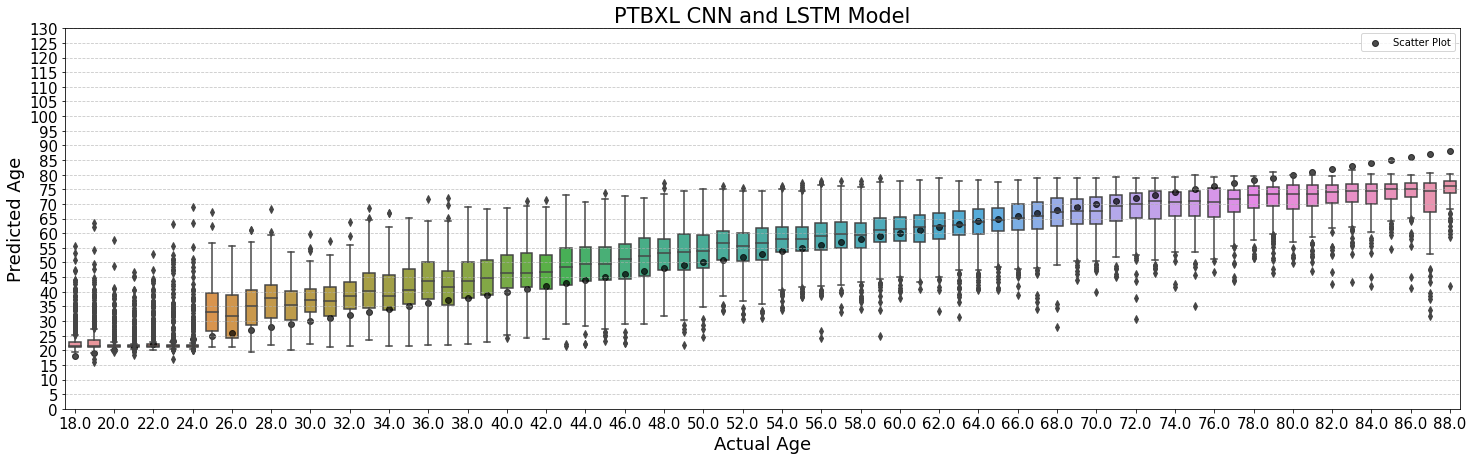

In [ ]:
age_bar(Y_filtered, predicted_age, title= "PTBXL CNN and LSTM Model")

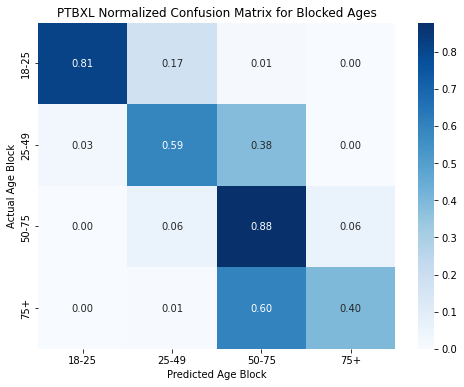

In [ ]:
age_cf(age_actual_blocked, age_pred_blocked, "PTBXL Normalized Confusion Matrix for Blocked Ages")

In [ ]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

mae = mean_absolute_error(Y_filtered, predicted_age)
mse = mean_squared_error(Y_filtered, predicted_age)**0.5

mae, mse

(6.60484199515731, 8.743172300680426)